In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import sklearn
from scipy import sparse
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV
import nltk
from pymystem3 import Mystem
from xgboost import XGBClassifier


## Посмотрим на данные

In [2]:
train_df = pd.read_csv("train.csv")
train_df.head()

,id,url,title,target
0,0,m.kp.md,"Экс-министр экономики Молдовы - главе МИДЭИ, ц...",False
1,1,www.kp.by,Эта песня стала известна многим телезрителям б...,False
2,2,fanserials.tv,Банши 4 сезон 2 серия Бремя красоты смотреть о...,False
3,3,colorbox.spb.ru,Не Беси Меня Картинки,False
4,4,tula-sport.ru,В Новомосковске сыграют следж-хоккеисты алекси...,False


In [3]:
test_df = pd.read_csv("test.csv")
test_df.head()

,id,url,title
0,135309,www.kommersant.ru,Шестой кассационный суд в Самаре начнет работу...
1,135310,urexpert.online,"Что такое индексация алиментов, кем и в каких ..."
2,135311,imperimeha.ru,Женщинам | Империя Меха - Part 12
3,135312,national-porn.com,"Небритые, волосатые киски: Порно всех стран и ..."
4,135313,2gis.ru,67


## Будем решать данную задачу с помощью стэкинга

## Проведем лемматизацию заголовков страниц

In [4]:
stop_words = nltk.corpus.stopwords.words('russian') # сохраим стоп-слова для последующей токенизации

In [5]:
m = Mystem()
def lemmatize(text, mystem=m):
    try:
        return "".join(m.lemmatize(text)).strip()  
    except:
        return " "

In [6]:
test_df.title = test_df.title.apply(lemmatize)

In [7]:
train_df.title = train_df.title.apply(lemmatize)

## Получим признаки с помощью TfidfVectorizer
__Будем обучать модель на n-граммах url, n-граммах заголовков, а также на словах и коллокациях заголовков.__

In [8]:
TFIDF_url = TfidfVectorizer(lowercase=True, ngram_range=(2, 4), analyzer = 'char',
                            max_df=0.9, min_df=5)

TFIDF_title_1 = TfidfVectorizer(lowercase=True,ngram_range=(1, 3),
                            stop_words=stop_words, min_df=5, max_df=0.9) # получаем n-граммы на словах

TFIDF_title_2 = TfidfVectorizer(lowercase=True,ngram_range=(2, 5), analyzer = 'char',
                             min_df=10, max_df=0.8) # получаем n-грамы на символах

# фичи для трейновой части
X_train_url = TFIDF_url.fit_transform(train_df.url.values)
X_train_title_1 = TFIDF_title_1.fit_transform(train_df.title.values)
X_train_title_2 = TFIDF_title_2.fit_transform(train_df.title.values)

X_train = sparse.hstack([X_train_url, sparse.hstack([X_train_title_1,X_train_title_2])])
X_train.shape
y_train = train_df["target"].astype(int).values

In [9]:
# фичи для тестовой части
X_test_url = TFIDF_url.transform(test_df.url.values)
X_test_title_1 = TFIDF_title_1.transform(test_df.title.values)
X_test_title_2 = TFIDF_title_2.transform(test_df.title.values)

X_test = sparse.hstack([X_test_url, sparse.hstack([X_test_title_1,X_test_title_2])])
X_test.shape # посмотрим на итоговый размер матрицы объекты-признаки

(165378, 295245)

### Для того, чтобы использовать стэкинг и не терять информацию, разделим данные на 3 фолда.  
 Будем получать метапризнаки для одного фолда обучая алгоритм на двух оставшихся. Таким образом, пройдя по всем трём фолдам будут получены метапризнаки для всех обектов.


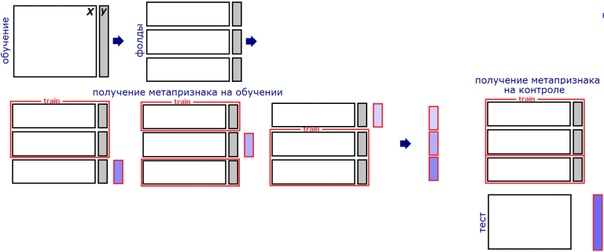

In [10]:
N = train_df.shape[0]

# получим признаковое описание и таргеты для каждого фолда
X_train_url_Fold_1 = TFIDF_url.transform(train_df[: int(N/3)].url.values)
X_train_title_1_Fold_1 = TFIDF_title_1.transform(train_df[: int(N/3)].title.values)
X_train_title_2_Fold_1 = TFIDF_title_2.transform(train_df[: int(N/3)].title.values)

X_train_Fold_1 = sparse.hstack([X_train_url_Fold_1, sparse.hstack([X_train_title_1_Fold_1, X_train_title_2_Fold_1])])
y_train_Fold_1 = train_df[: int(N/3)].target

X_train_url_Fold_2 = TFIDF_url.transform(train_df[int(N/3) : int(2*N/3)].url.values)
X_train_title_1_Fold_2 = TFIDF_title_1.transform(train_df[int(N/3) : int(2*N/3)].title.values)
X_train_title_2_Fold_2 = TFIDF_title_2.transform(train_df[int(N/3) : int(2*N/3)].title.values)

X_train_Fold_2 = sparse.hstack([X_train_url_Fold_2, sparse.hstack([X_train_title_1_Fold_2, X_train_title_2_Fold_2])])
y_train_Fold_2 = train_df[int(N/3) : int(2*N/3)].target


X_train_url_Fold_3 = TFIDF_url.transform(train_df[int(2*N/3) :].url.values)
X_train_title_1_Fold_3 = TFIDF_title_1.transform(train_df[int(2*N/3) :].title.values)
X_train_title_2_Fold_3 = TFIDF_title_2.transform(train_df[int(2*N/3) :].title.values)

X_train_Fold_3 = sparse.hstack([X_train_url_Fold_3, sparse.hstack([X_train_title_1_Fold_3, X_train_title_2_Fold_3])])
y_train_Fold_3 = train_df[int(2*N/3) :].target



## Напишем функцию для получения мета-признаков
Можно было бы делить X_train на фолды прямо в данной функции, однако это затруднительно из-за разряженного представления матрицы.

In [11]:
def predict_meta_feature(
    classifier, X_train_Fold_1, X_train_Fold_2, X_train_Fold_3
    , y_train_Fold_1, y_train_Fold_2, y_train_Fold_3
    , X_train, y_train, X_test):
    
    # получаем метапризнаки для каждого фолда, обучая при этом алгоритм на оставшихся двух
    
    classifier.fit(sparse.vstack([X_train_Fold_1, X_train_Fold_2]), np.hstack([y_train_Fold_1, y_train_Fold_2]))
    predict_3 = classifier.predict_proba(X_train_Fold_3)

    classifier.fit(sparse.vstack([X_train_Fold_2, X_train_Fold_3]), np.hstack([y_train_Fold_2, y_train_Fold_3]))
    predict_1 = classifier.predict_proba(X_train_Fold_1)

    classifier.fit(sparse.vstack([X_train_Fold_1, X_train_Fold_3]), np.hstack([y_train_Fold_1, y_train_Fold_3]))
    predict_2 = classifier.predict_proba(X_train_Fold_2)
    
    # выводим новые метапризнаки для трейновой части
    New_meta_feature_train = np.vstack([predict_1, np.vstack([predict_2, predict_3])])
    
    # обучаем алгоритм на всей трейновой выборки и получаем признаки для тестовой   
    classifier.fit(X_train, y_train)
    New_meta_feature_test = classifier.predict_proba(X_test)
    
    return New_meta_feature_train, New_meta_feature_test

## Получим мета-признаки используя логистическую регрессию

In [12]:
%%time

clf = LogisticRegression(max_iter = 10000,solver='lbfgs', class_weight='balanced')

meta_feature_LOG_REG_train, meta_feature_LOG_REG_test = predict_meta_feature(
    clf, X_train_Fold_1, X_train_Fold_2, X_train_Fold_3
       , y_train_Fold_1, y_train_Fold_2, y_train_Fold_3
       , X_train, y_train, X_test)


CPU times: user 1min 22s, sys: 586 ms, total: 1min 22s
Wall time: 1min 16s


## Получим мета-признаки используя наивного Байеса

In [13]:
%%time

clf = MultinomialNB()

meta_feature_MNB_train, meta_feature_MNB_test = predict_meta_feature(
    clf, X_train_Fold_1, X_train_Fold_2, X_train_Fold_3
       , y_train_Fold_1, y_train_Fold_2, y_train_Fold_3
       , X_train, y_train, X_test
)

CPU times: user 12.9 s, sys: 344 ms, total: 13.2 s
Wall time: 13.2 s


## И с помощью случайного леса

In [14]:
%%time

clf = RandomForestClassifier(n_estimators = 50)

meta_feature_RF_train, meta_feature_RF_test = predict_meta_feature(
    clf, X_train_Fold_1, X_train_Fold_2, X_train_Fold_3
       , y_train_Fold_1, y_train_Fold_2, y_train_Fold_3
       , X_train, y_train, X_test
)

CPU times: user 4min 57s, sys: 522 ms, total: 4min 57s
Wall time: 4min 57s


In [15]:
# объединим полученные метапризнаки в новое признаковое описание объектов
meta_features_train = np.hstack([meta_feature_LOG_REG_train, meta_feature_MNB_train])
meta_features_test = np.hstack([meta_feature_LOG_REG_test, meta_feature_MNB_test])

meta_features_train = np.hstack([meta_features_train, meta_feature_RF_train])
meta_features_test = np.hstack([meta_features_test, meta_feature_RF_test])

## Получим мета-признаки используя голосование 

In [16]:
%%time

classifier1 = LogisticRegression(max_iter = 10000,solver='lbfgs', class_weight='balanced')
classifier2 = MultinomialNB()
classifier3 = RandomForestClassifier(n_estimators = 50)

clf = VotingClassifier(
    estimators=[('lr', classifier1)
              , ('NB', classifier2)
              , ('rf', classifier3)], voting='soft'
)

meta_feature_voiting_train, meta_feature_voiting_test = predict_meta_feature(
    clf, X_train_Fold_1, X_train_Fold_2, X_train_Fold_3
       , y_train_Fold_1, y_train_Fold_2, y_train_Fold_3
       , X_train, y_train, X_test
)

CPU times: user 6min 33s, sys: 1.17 s, total: 6min 34s
Wall time: 6min 28s


In [17]:
meta_features_train = np.hstack([meta_features_train, meta_feature_voiting_train])
meta_features_test = np.hstack([meta_features_test, meta_feature_voiting_test])


## На полученных ранее мета-признаках обучим XGBoost для получения новых мета-признаков
### Найдем наилучшие параматры для бустинга с помощью перебора по сетке

In [18]:
%%time

parameters = {'learning_rate': [0.0005,0.001,0.005,0.01,0.02], 'n_estimators' : [5000, 1000]}
XGB = XGBClassifier()
clf = GridSearchCV(XGB, parameters, cv = 3, scoring = 'f1')
clf.fit(meta_features_train, y_train)

CPU times: user 2h 20min 46s, sys: 1min 14s, total: 2h 22min
Wall time: 35min 55s


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None,

In [19]:
clf.best_params_

{'learning_rate': 0.0005, 'n_estimators': 5000}

## Получим мета-признаки используя оптимальные параметры бустинга

In [18]:
%%time
# разобьем мета-фичи на три фолда также как делали с обычнми признаками
meta_feature_1_Fold = meta_features_train[:int(N/3)]
meta_feature_2_Fold = meta_features_train[int(N/3) : int(2*N/3)]
meta_feature_3_Fold = meta_features_train[int(2*N/3):]

classifier = XGBClassifier(n_estimators = 5000, learning_rate = 0.0005)

classifier.fit(np.vstack([meta_feature_1_Fold , meta_feature_2_Fold]),
               np.hstack([y_train_Fold_1, y_train_Fold_2]))

predict_3 = classifier.predict_proba(meta_feature_3_Fold)


classifier.fit(np.vstack([meta_feature_2_Fold, meta_feature_3_Fold]), 
               np.hstack([y_train_Fold_2, y_train_Fold_3]))

predict_1 = classifier.predict_proba(meta_feature_1_Fold)

classifier.fit(np.vstack([meta_feature_1_Fold , meta_feature_3_Fold]), np.hstack([y_train_Fold_1, y_train_Fold_3]))
predict_2 = classifier.predict_proba(meta_feature_2_Fold)

meta_feature_XGB_second_train = np.vstack([predict_1, np.vstack([predict_2, predict_3])])

classifier.fit(meta_features_train, y_train)
meta_feature_XGB_second_test = classifier.predict_proba(meta_features_test)

CPU times: user 32min 14s, sys: 13 s, total: 32min 27s
Wall time: 9min 28s


In [19]:
meta_features_train = np.hstack([meta_features_train, meta_feature_XGB_second_train])
meta_features_test = np.hstack([meta_features_test, meta_feature_XGB_second_test])

# для соединения мета-признаков с обычными перезапишем их в виде разряженной матрицы
meta_features_train_sparse = sparse.csr_matrix(meta_features_train)
meta_features_test_sparse = sparse.csr_matrix(meta_features_test)

## Проверим с помощью кросс-валидации мета-алогритм, обученный на обычных признаках + мета-признаках
 В качестве мета-алгоритма возьмём __случайный лес__. Так как на таком количестве признаков перебирать параметры по сетке затруднительно, воспользуемся тем, что лес не переобучается с ростом деревьев и возьмём 500 деревьев.
 
 
Так как TfidfVectorizer был обучен на всей обучающей выборке, результаты кросс валидации могут быть завышены

In [20]:
%%time

base_cv_scores = cross_val_score(RandomForestClassifier(n_estimators = 500), 
                                 sparse.hstack([X_train, meta_features_train_sparse]),
                                 y_train, cv=5, scoring='f1')
base_cv_scores.mean() 

CPU times: user 39min 32s, sys: 2 s, total: 39min 34s
Wall time: 40min 49s


0.9873913715353348

### Таким образом были получены 10 мета-признаков

In [21]:
meta_features_train_sparse.shape

(135309, 10)

## Обучим мета-алгоритм на всей обучающей выборке и получим метки для тестовой выборки

In [22]:
%%time

classifier = RandomForestClassifier(n_estimators = 500)

classifier.fit(sparse.hstack([X_train, meta_features_train_sparse]), y_train)

test_df["target"] = classifier.predict(sparse.hstack([X_test, meta_features_test_sparse])).astype(bool)
test_df[["id", "target"]].to_csv("stacking_500_estimators.csv", index=False)

CPU times: user 12min 8s, sys: 322 ms, total: 12min 9s
Wall time: 12min 10s


# Вывод
В ходе работы были спользованыследующие методы построения ансамблей:
1. __Стэкинг__. Обучающая выборка была разделена на три фолда. На каждой паре фолдов были обучены модели, которые делали предсазание для оставшегося фолда. Все три предсказания соединялись и получался мета-признак (точнее два). Для получения мета-признаков для тестовой выборки модели обучались на всей обучающей выборки и делалось предсказание для тестовой. Таким образом было получено 10 мета-признаков(LogReg, NB, RandomForest, Voitiong, XGBoost) и на исходных признаках + мета-признаках был обучен мета-алгоритм.
2. __Случайный Лес__. Данный алгоритм был использован как мета-алгоритм, а также для получения мета-признаков
3. __Голосование__. С помощью голосования также были получены мета-признаки. Голосование проводилось на основание Логистической регрессии, Наивного Байеса, Случайного леса.
4. __Градиентный бустинг__. Полученные на предидущих шагах мета-признаки были использованы для получения новых мета-признаков с помощью градиентного бустинга. Оптимальные параметры бустинга были подобраны с помощью __перебора по сетке__ .


Если строить модель на n-граммах url и title, а также на коллокациях получается около 300 000 признаков. Из-за этого написанная модель очень медленно обучается. Если в качестве признаков рассматривать только n-граммы url и токены title признаковое пространство можно сократить до 50 000. При этом f1-score описанной модели, обученной на таком кол-ве признаков, будет отличаться только в 3 знаке после запятой от модели обученной на 3000 000 признаках. 

Также хороший результат показывает обычная логистическая регрессия, обученныя на 300 000 признаках. При данном подходе f1-score будет отличаться только в 3 знаке после запятой, а время обучения модели существенно сократится. Такой подход показался мне наиболее оптимальным.  

